# Estimate APA duration.

Analysis aiming to show that the interesting part of APAs lasts 60ms

To do this, we take the trace for the FR at each trial. 
We fit a 3-segment piece-wise linear curve to it.
We look at the middle segment (corresponding to when the mouse lifts the paw) and it's extent in time. 

In [139]:
import sys
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind as ttest
import pandas as pd
from sklearn.preprocessing import StandardScaler


import numpy as np
import os
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d

basepath = r"C:\Users\Federico\Documents\GitHub\APA_setup"
os.chdir(basepath)

sys.path.append("./")
sys.path.append(basepath)
sys.path.append(os.path.join(basepath, "analysis"))


from fcutils.plot.distributions import plot_kde
from fcutils.plot.figure import clean_axes
from analysis.process_data import DataProcessing
from analysis.fixtures import colors, sensors
from myterial import indigo, blue_grey_dark, salmon, cyan_dark

data = DataProcessing.reload()



[07/10/22 15:04:05] INFO     Starting data pre-processing with trials     ]8;id=747203;file://C:\Users\Federico\Documents\GitHub\APA_setup\analysis\process_data.py\process_data.py]8;;\:]8;id=970718;file://C:\Users\Federico\Documents\GitHub\APA_setup\analysis\process_data.py#113\113]8;;\
                             file: F:\Egzona\Forceplate\Old trial                            
                             analysis files\100422_ALLtrials_CTRL-DTR_con                    
                             ditions.csv.                                                    

                    INFO     Caliration file: F:\Egzona\Forceplate\forcep ]8;id=422573;file://C:\Users\Federico\Documents\GitHub\APA_setup\analysis\process_data.py\process_data.py]8;;\:]8;id=844638;file://C:\Users\Federico\Documents\GitHub\APA_setup\analysis\process_data.py#116\116]8;;\
                             latesensors_calibration4.csv.                                   

                    INFO     Found 36 subfolders                           ]8;id=638134;file://C:\Users\Federico\Documents\GitHub\APA_setup\analysis\process_data.py\process_data.py]8;;\:]8;id=949038;file://C:\Users\Federico\Documents\GitHub\APA_setup\analysis\process_data.py#54\54]8;;\

                    DEBUG    Setting previously stored params: {'DEBUG':   ]8;id=432531;file://C:\Users\Federico\Documents\GitHub\APA_setup\analysis\process_data.py\process_data.py]8;;\:]8;id=318978;file://C:\Users\Federico\Documents\GitHub\APA_setup\analysis\process_data.py#89\89]8;;\
                             True, 'CONDITIONS': ['WT', 'CTRL', 'DTR'],                      
                             'STANDING_STILL': False, 'calibrate': True,                     
                             'weight_percentage': True, 'correct_for_paw':                   
                             True, 'frames_file':                                            
                             'F:\\Egzona\\Forceplate\\Old trial analysis f                   
                             iles\\100422_ALLtrials_CTRL-DTR_conditions.cs                   
                             v', 'calibration_file': 'F:\\Egzona\\Forcepla                   
                             te\\forceplatesensors_calibration4.csv',                        
                             'main_fld': 'F:\\Egzona\\Forceplate\\CURRENT                    
                             ANALYSIS TRIALS', 'fps': 600,                                   
                             'smoothing_window': 0.01,                                       
                             'on_sensor_weight_th': 2,                                       
                             'on_all_sensors_weight_th': 66,                                 
                             'n_secs_before': 0.2, 'n_secs_after': 0.2,                      
                             'min_baseline_duration': 0,                                     
                             'trial_start_detection_window': 0.15,                           
                             'plot_individual_trials': False}                                

                    INFO     Starting data pre-processing with trials     ]8;id=210533;file://C:\Users\Federico\Documents\GitHub\APA_setup\analysis\process_data.py\process_data.py]8;;\:]8;id=569043;file://C:\Users\Federico\Documents\GitHub\APA_setup\analysis\process_data.py#113\113]8;;\
                             file: F:\Egzona\Forceplate\Old trial                            
                             analysis files\100422_ALLtrials_CTRL-DTR_con                    
                             ditions.csv.                                                    

                    INFO     Caliration file: F:\Egzona\Forceplate\forcep ]8;id=143501;file://C:\Users\Federico\Documents\GitHub\APA_setup\analysis\process_data.py\process_data.py]8;;\:]8;id=625494;file://C:\Users\Federico\Documents\GitHub\APA_setup\analysis\process_data.py#116\116]8;;\
                             latesensors_calibration4.csv.                                   

                    INFO     Loading previously saved data from:           ]8;id=999132;file://C:\Users\Federico\Documents\GitHub\APA_setup\analysis\process_data.py\process_data.py]8;;\:]8;id=79537;file://C:\Users\Federico\Documents\GitHub\APA_setup\analysis\process_data.py#93\93]8;;\
                             F:\Egzona\Forceplate\CURRENT ANALYSIS                           
                             TRIALS\data.h5                                                  

                    INFO     Loaded 74 trials -----                        ]8;id=911551;file://C:\Users\Federico\Documents\GitHub\APA_setup\analysis\process_data.py\process_data.py]8;;\:]8;id=375479;file://C:\Users\Federico\Documents\GitHub\APA_setup\analysis\process_data.py#95\95]8;;\
                                                                                             
                                                                                             

select trials by strain/condition

In [140]:
CONDITION = "DTR"
STRAIN = "C57"

if STRAIN is not None:
    data = data.data.loc[(data.data.condition == CONDITION)&(data.data.strain == STRAIN)].reset_index()
else:
    data = data.data.loc[(data.data.condition == CONDITION)].reset_index()
    STRAIN = "any"
print(len(data))


15


In [141]:
def get_traces(condition_trials:pd.DataFrame, t0=85, t1=140, subtractbl=True)->np.ndarray:
    """
        Get traces for all trials in a condition between the
        two reference frames. Returns an array of shape (4, n_frames, n_trials).
    """
    traces = np.zeros((4, t1 - t0, len(condition_trials)))

    for i, trial in condition_trials.iterrows():
        for n, paw in enumerate(sensors):
            bl = np.mean(trial[paw][0:85]) if subtractbl else 0
            traces[n, :, i] = trial[paw][t0:t1] -  bl  # remove baseline

    return traces



In [142]:

# frames ranges for cutting traces
trial_start_frame = 0
trial_end_frame = 239
APA_start_frame = 85

wt_traces_complete = get_traces(data, t0=trial_start_frame, t1=trial_end_frame, subtractbl=False)

time_frames = np.arange(trial_start_frame - 120, trial_end_frame - 120, 1)


In [143]:
from scipy import optimize


def ms2frame(ms):
    return int(ms / 1000 * 600)

def frame2ms(frame):
    return frame / 600 * 1000

def segments_fit(X, Y, count):
    """
        from https://gist.github.com/ruoyu0088/70effade57483355bbd18b31dc370f2a
    """
    xmin = X.min()
    xmax = X.max()

    seg = np.full(count - 1, (xmax - xmin) / count)

    px_init = np.r_[np.r_[xmin, seg].cumsum(), xmax]
    py_init = np.array([Y[np.abs(X - x) < (xmax - xmin) * 0.01].mean() for x in px_init])

    def func(p):
        seg = p[:count - 1]
        py = p[count - 1:]
        px = np.r_[np.r_[xmin, seg].cumsum(), xmax]
        return px, py

    def err(p):
        px, py = func(p)
        Y2 = np.interp(X, px, py)
        return np.mean((Y - Y2)**2)

    r = optimize.minimize(err, x0=np.r_[seg, py_init], method='Nelder-Mead')
    return func(r.x)


In [144]:
# set font size for labels in matplotlib
plt.rcParams.update({'font.size': 14})

<Figure size 720x720 with 1 Axes>

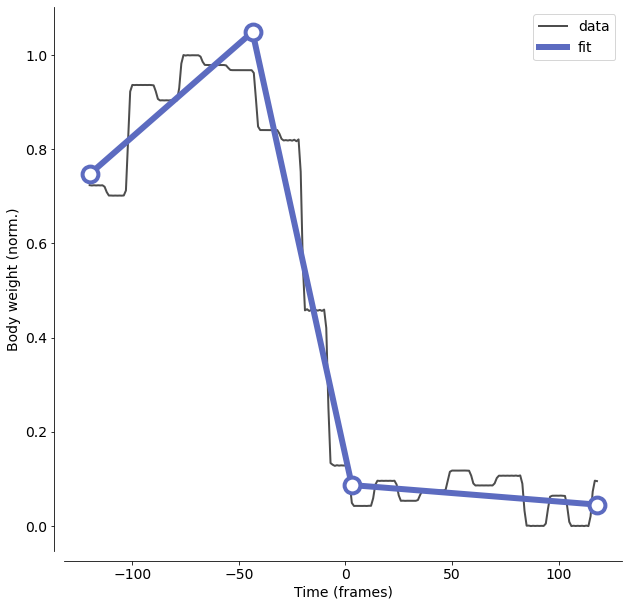

In [145]:
f, ax = plt.subplots(figsize=(10, 10),)


durations = []
for n, trial in enumerate(range(wt_traces_complete.shape[-1])):
    y = wt_traces_complete[1, :, trial]
    
    # scale y between 0, 1
    y = (y - y.min()) / (y.max() - y.min())
    

    # fit a piece-wise linear curve
    px, py = segments_fit(time_frames, y, 3)
    if n == 0:
        ax.plot(time_frames, y, color=[.3, .3, .3], lw=2, alpha=1, label="data")
        ax.plot(px, py, color=indigo, alpha=1, lw=6, label="fit")
        ax.scatter(px, py, s=250, lw=4, ec=indigo, fc="white", zorder=100)
    durations.append(px[2] - px[1])

    # break


from pathlib import Path
savepath = Path(r"C:\Users\Federico\Desktop\forE")

# save figure at savepath
ax.legend()
ax.set(xlabel="Time (frames)", ylabel="Body weight (norm.)")
clean_axes(f)
f.savefig(savepath / f"apa_duration_piecewisefit_example_condition_{CONDITION}_strain_{STRAIN}.png", dpi=300)


### plot durations

low 3.691 ms high 194.808 ms, mean 80.362 ms, median 65.637 ms, std: 65.140 ms


<Figure size 1152x648 with 1 Axes>

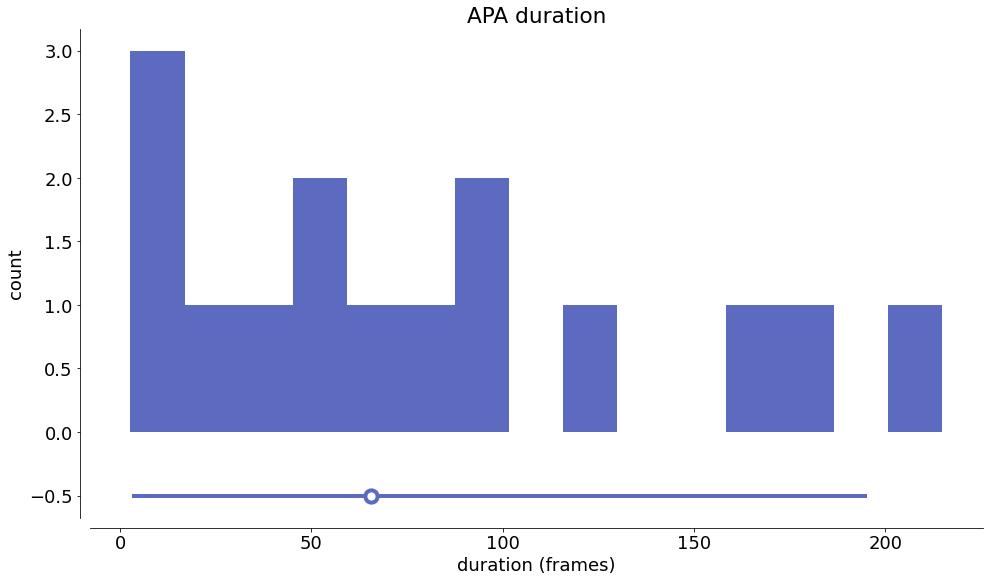

In [146]:
plt.rcParams.update({'font.size': 18})
f, ax = plt.subplots(figsize=(16, 9))

durations_ms = [frame2ms(d) for d in durations]

low, high = np.percentile(durations_ms, [5, 95])
print(f"low {low:.3f} ms high {high:.3f} ms, mean {np.mean(durations_ms):.3f} ms, median {np.median(durations_ms):.3f} ms, std: {np.std(durations_ms):.3f} ms")

ax.hist(durations_ms, bins=15, color=indigo)
ax.plot([low, high], [-.5, -.5], "-", color=indigo, lw=4)
ax.scatter(np.median(durations_ms), -.5, color="white", lw=4, ec=indigo, zorder=100,  s=150)

_ = ax.set(xlabel="duration (frames)", ylabel="count", title="APA duration")

clean_axes(f)
f.savefig(savepath / f"apa_duration_distribution_{CONDITION}_strain_{STRAIN}.png", dpi=500)
